In [1]:
 ### Simulation of co-culture

%reset -f

import os

os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

In [2]:
import cobra as cb
import cometspy as c
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:

trace_metabolites = {
    "h2o[e]", "pi[e]", "fe2[e]", "fe3[e]", "zn2[e]", "so4[e]", "cu2[e]", "k[e]", "mg2[e]",
    "mn2[e]", "cd2[e]", "cl[e]", "ca2[e]", "cobalt2[e]", "ribflv[e]",
    "pnto_R[e]", "nac[e]", "his_L[e]", "asn_L[e]", "glycys[e]", "lys_L[e]", "ala_L[e]",
    "met_L[e]", "leu_L[e]", "hxan[e]"
}

base_media = {"nh4[e]": 20.0, 'glyglu[e]':10}

#Load model
base1 = cb.io.load_matlab_model("Bifidobacterium_longum_infantis_ATCC_15697.mat")   # Bifido
base2 = cb.io.load_matlab_model("Eubacterium_hallii_DSM_3353.mat")                  # Eubacterium


met_to_ex1 = {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex1[met.id] = rxn.id

met_to_ex2 = {}
for rxn in base2.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex2[met.id] = rxn.id

all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())


def add_missing_closed_exchanges(model, met_to_ex_self_real, all_ext_mets, label):
    """
    For each external metabolite in all_ext_mets that this model doesn't have
    a REAL exchange for, add a CLOSED dummy exchange:
        EX_added_<met_id> with LB=0, UB=0.
    """
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}

    for met_id in all_ext_mets:
        if met_id in met_to_ex_self_real:
            continue

        # Ensure external metabolite exists
        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment="e")
            model.add_metabolites([met])
            met_ids.add(met_id)

        # Add closed dummy exchange
        rxn_id = f"EX_added_{met_id}"
        if rxn_id in rxn_ids:
            continue

        rxn = cb.Reaction(rxn_id)
        rxn.name = f"Dummy exchange for {met_id} (closed)"
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)

add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, "Bifido")
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, "Eubacterium")


# Co-culture 
def run_coculture(glc, lac, bif_init, eub_init=0.01):
    bif = c.model(base1.copy())
    bif.id = "Bifido"

    eub = c.model(base2.copy())
    eub.id = "Eubacterium"

    bif.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
    eub.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

    # Clean non-EX exchanges
    for m in [bif, eub]:
            ex_mask = m.reactions["EXCH"].isin([True, "True"])
            exchanges_df = m.reactions[ex_mask]
            for name in exchanges_df["REACTION_NAMES"]:
                name = str(name)
                if not name.startswith("EX_"):
                    m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
                    m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


    bif.open_exchanges()
    eub.open_exchanges()

    bif.initial_pop = [0, 0, float(bif_init)]
    eub.initial_pop = [0, 0, float(eub_init)]

    layout = c.layout([bif, eub])
    layout.grid = [1, 1]

    # Track all externals 
    for met in all_ext_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    # Trace metabolites
    for met in trace_metabolites:
        if met in all_ext_mets:
            layout.set_specific_metabolite(met, 1000.0)
            layout.set_specific_static(met, 1000)

    # Base medium + carbon sources
    lb_media = dict(base_media)
    lb_media["glc_D[e]"] = float(glc)
    if float(lac) != 0.0:
        lb_media["lac_L[e]"] = float(lac)

    for met, amt in lb_media.items():
        if met in all_ext_mets:
            layout.set_specific_metabolite(met, float(amt))
            layout.set_specific_refresh(met, 0.0)

    # Params 
    vol = 0.1
    params = c.params()
    params.set_param("spaceWidth", vol ** (1/3))
    params.set_param("defaultVmax", 10.0)
    params.set_param("defaultKm", 0.01)
    params.set_param("timeStep", 0.1)
    params.set_param("maxCycles", 100)
    params.set_param("maxSpaceBiomass", 10.0)
    params.set_param("minSpaceBiomass", 1e-11)

    params.set_param("writeMediaLog", True)
    params.set_param("MediaLogRate", 1)
    params.set_param("writeBiomassLog", True)
    params.set_param("BiomassLogRate", 1)
    params.set_param("writeFluxLog", False)
    params.set_param("exchangestyle", "Monod Style")

    sim = c.comets(layout, params)
    sim.run()
    return sim

# Run
sims = {}

bif_inits = np.logspace(np.log10(0.01), np.log10(0.1), 5)  
eub_init_fixed = 0.01

glc = 5.0
lac = 10.0

for b0 in bif_inits:
    print(f"Running glc={glc:g}, lac={lac:g}, bif_init={b0:g}")
    sims[(glc, lac, float(b0))] = run_coculture(glc, lac, bif_init=float(b0), eub_init=eub_init_fixed)


# glucose_values = np.linspace(10.0, 2.0, 3)
# lactate_values = np.linspace(0.0, 16.0, 3)

# for glc, lac in zip(glucose_values, lactate_values):
#     for b0 in bif_inits:
#         print(f"Running glc={glc:g}, lac={lac:g}, bif_init={b0:g}")
#         sims[(float(glc), float(lac), float(b0))] = run_coculture(float(glc), float(lac),
#                                                                  bif_init=float(b0),
#                                                                  eub_init=eub_init_fixed)

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Running glc=5, lac=10, bif_init=0.01

Running COMETS simulation ...
Done!
Running glc=5, lac=10, bif_init=0.0177828

Running COMETS simulation ...
Done!
Running glc=5, lac=10, bif_init=0.0316228

Running COMETS simulation ...


KeyboardInterrupt: 

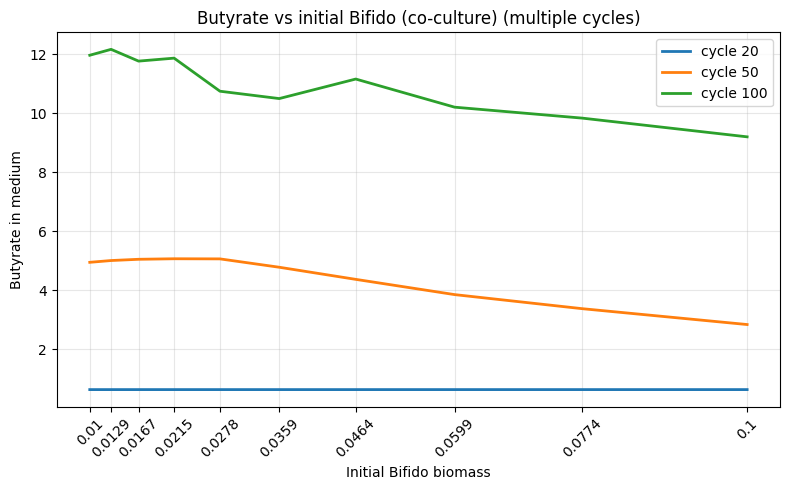

In [4]:
cycles = [20, 50, 100]  

x_bif = []
but_at_cycle = {c: [] for c in cycles}

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):

    media = sim.get_metabolite_time_series()

    # x-axis: initial Bifido
    x_bif.append(b0)

    # y-axis: butyrate at selected cycles
    but_series = media["but[e]"].values if "but[e]" in media.columns else None
    for c in cycles:
        but_at_cycle[c].append(but_series[c])

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(x_bif, but_at_cycle[c], linewidth=2, label=f"cycle {c}")

#plt.xscale("log")    # because bif_inits is logspace
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel("Butyrate in medium")
plt.title("Butyrate vs initial Bifido (co-culture) (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

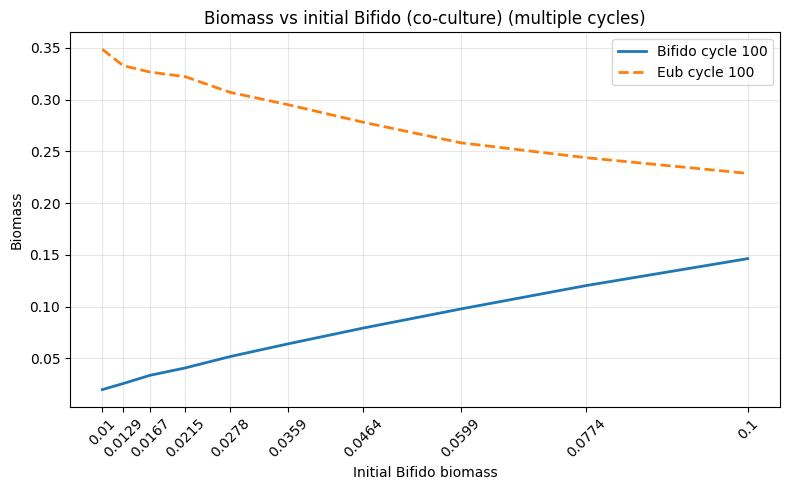

In [5]:
cycles = [100]  

x_bif = []
bif_biomass_at_cycle = {c: [] for c in cycles}
eub_biomass_at_cycle = {c: [] for c in cycles}

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):
    
    x_bif.append(b0)

    bb = sim.total_biomass["Bifido"].values
    eb = sim.total_biomass["Eubacterium"].values

    for c in cycles:
        bif_biomass_at_cycle[c].append(bb[c])
        eub_biomass_at_cycle[c].append(eb[c])

plt.figure(figsize=(8, 5))

for c in cycles:
    plt.plot(x_bif, bif_biomass_at_cycle[c], linewidth=2, label=f"Bifido cycle {c}")
    plt.plot(x_bif, eub_biomass_at_cycle[c], linewidth=2, linestyle="--", label=f"Eub cycle {c}")

#plt.xscale("log")  # because bif_inits is logspace
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel("Biomass")
plt.title("Biomass vs initial Bifido (co-culture) (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

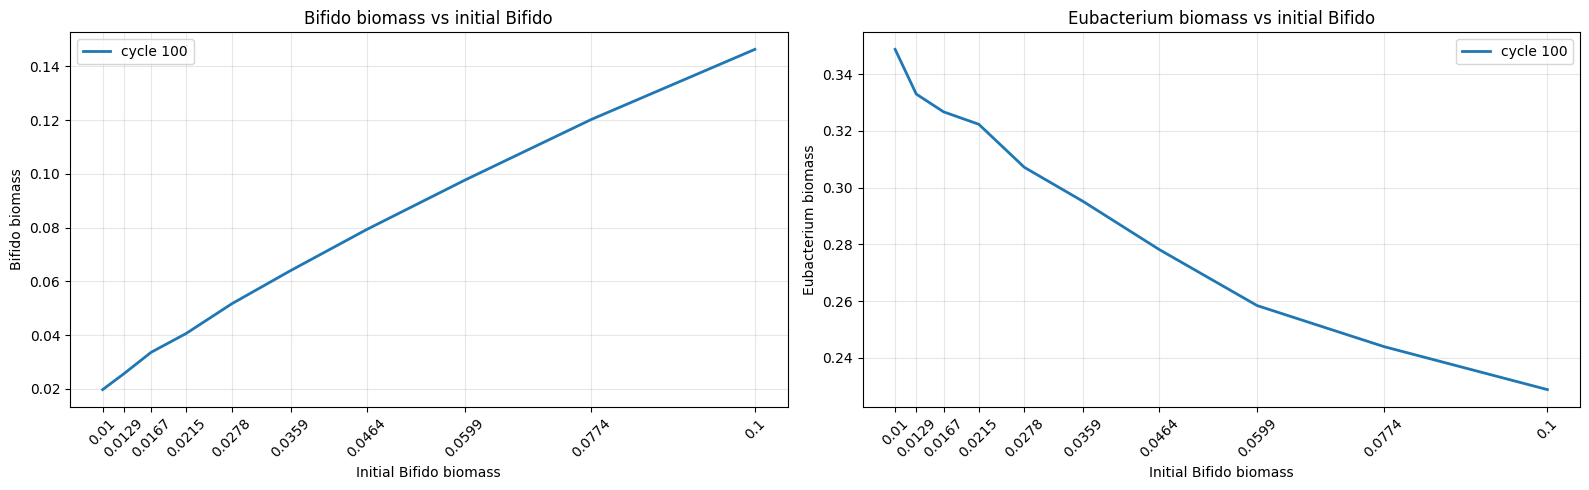

In [6]:
cycles = [100]  

x_bif = []
bif_biomass_at_cycle = {c: [] for c in cycles}
eub_biomass_at_cycle = {c: [] for c in cycles}

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):
    x_bif.append(b0)

    bb = sim.total_biomass["Bifido"].values
    eb = sim.total_biomass["Eubacterium"].values

    for c in cycles:
        bif_biomass_at_cycle[c].append(bb[c] if c < len(bb) else np.nan)
        eub_biomass_at_cycle[c].append(eb[c] if c < len(eb) else np.nan)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

# Subplot 1: Bifido
ax = axes[0]
for c in cycles:
    ax.plot(x_bif, bif_biomass_at_cycle[c], linewidth=2, label=f"cycle {c}")
# ax.set_xscale("log")
ax.set_xticks(x_bif)
ax.set_xticklabels([f"{v:.3g}" for v in x_bif], rotation=45)
ax.set_xlabel("Initial Bifido biomass")
ax.set_ylabel("Bifido biomass")
ax.set_title("Bifido biomass vs initial Bifido")
ax.grid(alpha=0.3)
ax.legend()

# Subplot 2: Eubacterium
ax = axes[1]
for c in cycles:
    ax.plot(x_bif, eub_biomass_at_cycle[c], linewidth=2, label=f"cycle {c}")
# ax.set_xscale("log")
ax.set_xticks(x_bif)
ax.set_xticklabels([f"{v:.3g}" for v in x_bif], rotation=45)
ax.set_xlabel("Initial Bifido biomass")
ax.set_ylabel("Eubacterium biomass")
ax.set_title("Eubacterium biomass vs initial Bifido")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

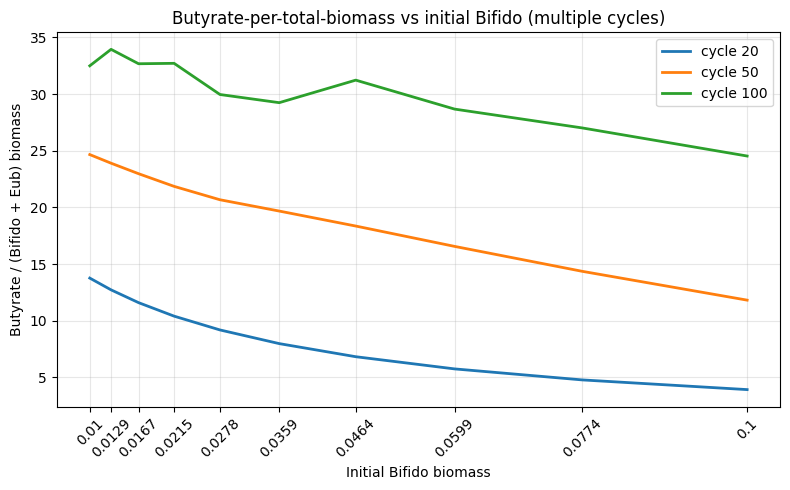

In [ ]:
cycles = [20, 50, 100] 

x_bif = []
ratio_at_cycle = {c: [] for c in cycles}

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):
    
    x_bif.append(b0)

    media = sim.get_metabolite_time_series()
    but_series = media["but[e]"].values if "but[e]" in media.columns else None

    bb = sim.total_biomass["Bifido"].values
    eb = sim.total_biomass["Eubacterium"].values

    for c in cycles:
       
        but_c = but_series[c] 
        bbf = bb[c] 
        ebf = eb[c]
        
        #denom = bbf + ebf
        denom =  ebf
        if np.isnan(but_c) or np.isnan(denom) or denom == 0:
            ratio_at_cycle[c].append(np.nan)
        else:
            ratio_at_cycle[c].append(but_c / denom)

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(x_bif, ratio_at_cycle[c], linewidth=2, label=f"cycle {c}")

#plt.xscale("log")  # because bif_inits is logspace
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel("Butyrate / (Bifido + Eub) biomass")
plt.title("Butyrate-per-total-biomass vs initial Bifido (multiple cycles)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Efficiency optimum (cycle = 100 )
  best initial Bifido = 0.1
  butyrate / total biomass = 24.53404832169383
  butyrate = 9.2044727467
  Bifido biomass = 0.14636458726
  Eubacterium biomass = 0.22880679196


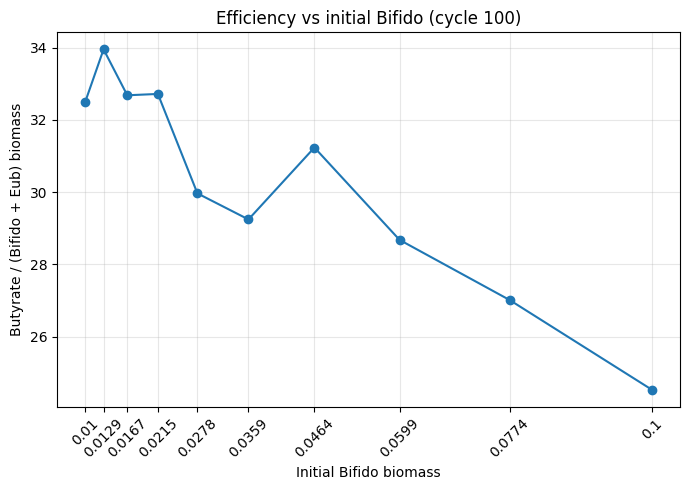

In [9]:

cycle = 100  # or 20/50/100

rows = []
for (glc, lac, b0), sim in sims.items():
    media = sim.get_metabolite_time_series()

    but_series = media["but[e]"].values 
    but_c = but_series[cycle] 
    
    bb = sim.total_biomass["Bifido"].values
    eb = sim.total_biomass["Eubacterium"].values
    bbf = bb[cycle] 
    ebf = eb[cycle] 

    denom = bbf + ebf

    eff = but_c / denom 

    rows.append((b0, eff, but_c, bbf, ebf))


for b0, eff, but_c, bbf, ebf in rows:
    best = (b0, eff, but_c, bbf, ebf)

print("Efficiency optimum (cycle =", cycle, ")")
print("  best initial Bifido =", best[0])
print("  butyrate / total biomass =", best[1])
print("  butyrate =", best[2])
print("  Bifido biomass =", best[3])
print("  Eubacterium biomass =", best[4])

# optional: plot efficiency vs initial Bifido
rows_sorted = sorted([r for r in rows if not np.isnan(r[1])], key=lambda x: x[0])
x = [r[0] for r in rows_sorted]
y = [r[1] for r in rows_sorted]

plt.figure(figsize=(7,5))
plt.plot(x, y, marker="o")
# plt.xscale("log")
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel("Butyrate / (Bifido + Eub) biomass")
plt.title(f"Efficiency vs initial Bifido (cycle {cycle})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Best lactate->butyrate conversion (cycle = 100 )
  best initial Bifido = 0.1
  yield (but_made / lac_consumed) = 2.9145836336388644
  butyrate made = 9.2044727467
  lactate consumed = 3.1580746699000004


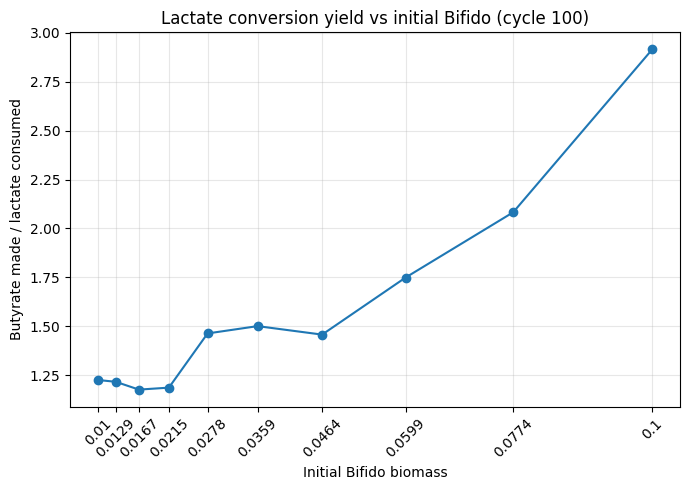

In [15]:
cycle = 100  

x_bif = []
yield_at_b0 = []
but_made_list = []
lac_cons_list = []

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):
    media = sim.get_metabolite_time_series()

    # butyrate made = but(cycle) 
    but_series = media["but[e]"].values
    butc = but_series[cycle] 
    but_made = butc 

    # lactate consumed = lactate_feed - lactate_remaining(cycle)
    lac_series = media["lac_L[e]"].values
    lacc = lac_series[cycle] 
    lac_consumed = float(lac) - lacc

    # yield
    yld = (but_made / lac_consumed) 

    x_bif.append(b0)
    yield_at_b0.append(yld)
    but_made_list.append(but_made)
    lac_cons_list.append(lac_consumed)

# best b0 
best = None
for b0, yld, but_made, lac_cons in zip(x_bif, yield_at_b0, but_made_list, lac_cons_list):
    best = (b0, yld, but_made, lac_cons)

print("Best lactate->butyrate conversion (cycle =", cycle, ")")
print("  best initial Bifido =", best[0])
print("  yield (but_made / lac_consumed) =", best[1])
print("  butyrate made =", best[2])
print("  lactate consumed =", best[3])

# plot yield vs initial Bifido
plt.figure(figsize=(7,5))
plt.plot(x_bif, yield_at_b0, marker="o")
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel("Butyrate made / lactate consumed")
plt.title(f"Lactate conversion yield vs initial Bifido (cycle {cycle})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

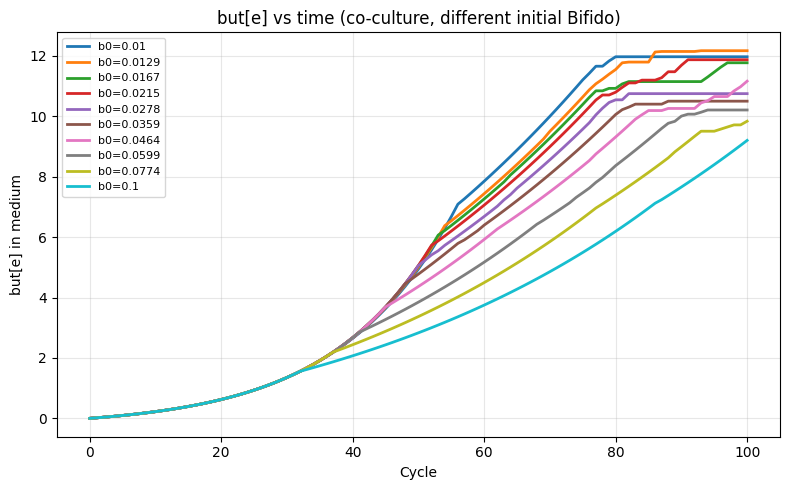

In [19]:
met = "but[e]"   

plt.figure(figsize=(8, 5))

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):
    media = sim.get_metabolite_time_series()

    ac_series = media[met].values
    plt.plot(ac_series, linewidth=2, label=f"b0={b0:.3g}")

plt.xlabel("Cycle")
plt.ylabel(f"{met} in medium")
plt.title(f"{met} vs time (co-culture, different initial Bifido)")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

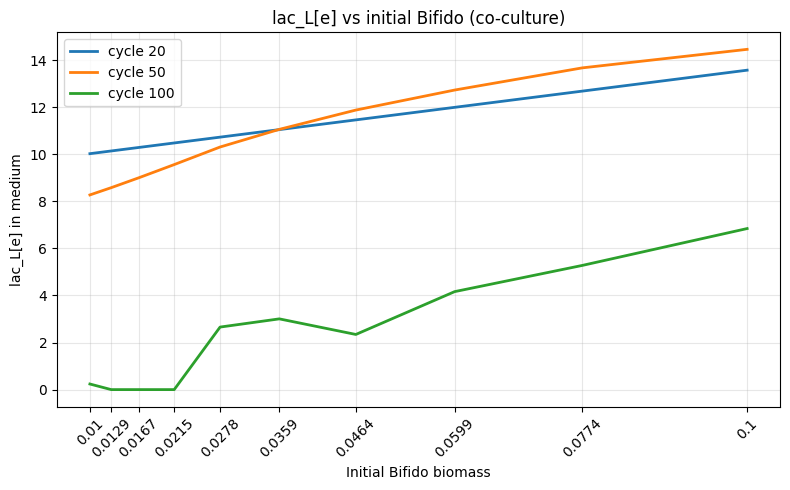

In [21]:
met = "lac_L[e]"
cycles = [20, 50, 100]

x_bif = []
ac_at_cycle = {c: [] for c in cycles}

for (glc, lac, b0), sim in sorted(sims.items(), key=lambda kv: kv[0][2]):

    media = sim.get_metabolite_time_series()

    x_bif.append(b0)
    ac_series = media[met].values

    for c in cycles:
        ac_at_cycle[c].append(ac_series[c])

plt.figure(figsize=(8, 5))
for c in cycles:
    plt.plot(x_bif, ac_at_cycle[c], linewidth=2, label=f"cycle {c}")

# plt.xscale("log")
plt.xticks(x_bif, [f"{v:.3g}" for v in x_bif], rotation=45)
plt.xlabel("Initial Bifido biomass")
plt.ylabel(f"{met} in medium")
plt.title(f"{met} vs initial Bifido (co-culture)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def find_met_hits(model, query="glyglu"):
    q = query.lower()
    hits = []
    for met in model.metabolites:
        met_id = (met.id or "")
        met_name = (getattr(met, "name", "") or "")
        if q in met_id.lower() or q in met_name.lower():
            hits.append((met_id, met_name))
    return hits

for label, model in [("base1", base1), ("base2", base2)]:
    hits = find_met_hits(model, "glyglu")
    print(label, "hits:", len(hits))
    for met_id, met_name in hits[:30]:
        print("  ", met_id, "|", met_name)

base1 hits: 2
   glyglu[c] | Glycyl-L-glutamate
   glyglu[e] | Glycyl-L-glutamate
base2 hits: 2
   glyglu[c] | Glycyl-L-glutamate
   glyglu[e] | Glycyl-L-glutamate
